In [1]:
import numpy as np
import pandas as pd
import pickle

col_names = pd.read_csv('../data/dataset.csv', nrows=0).columns
dtype_map = {'class' : np.int16, 'bankruptcy_after_years' : np.int16}
dtype_map.update({col: np.float64 for col in col_names if col not in dtype_map})

df = pd.read_csv('../data/dataset.csv', dtype=dtype_map)
df = df.drop([df.columns[0], df.columns[1], df.columns[2], 'year'], axis=1)
df.drop_duplicates(keep=False, inplace=True)

df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,bankruptcy_after_years
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,0


XGBoost model and k-fold cross-validation, binary classification:

In [2]:
import numpy as np
from scikitplot.metrics import plot_precision_recall
import matplotlib.pyplot as plt
   
    
def save_model(model, frs, label, out_dir):
    model.fit(frs, label)
    pickle.dump(model, open(out_dir,'wb'))
    
def validate(in_dir, X_test, y_test, title):
    model = pickle.load(open(in_dir,'rb'))
    y_probas = model.predict_proba(X_test)
    plot_precision_recall(y_test, y_probas,
                          title=str('Precision-recall curve micro-averaged over all classes for ' + title))
    plt.show()

In [3]:
df['bankruptcy_after_years'].value_counts()

0    40534
2      511
3      491
1      406
4      396
5      271
Name: bankruptcy_after_years, dtype: int64

Impute missing values and perform SMOTE (Synthetic Minority Over-sampling) for balancing data:

In [4]:
from sklearn.impute import SimpleImputer
import gc
import numpy as np
from imblearn.over_sampling import SMOTE

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_data = imp.fit_transform(df)
imp_data_df = pd.DataFrame(imp_data, index=df.index, columns=df.columns)

X = imp_data_df[imp_data_df.columns.difference(['bankruptcy_after_years', 'class'])]
Y = imp_data_df['bankruptcy_after_years']

del imp_data, imp_data_df
gc.collect()


sm = SMOTE(random_state=111)
X_smote, y_smote = sm.fit_resample(X, Y)

Split data to the train and test splits for imputed+SMOTE data:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3)

Random undersampling with kept missing values for balancing data:

In [6]:
from imblearn.under_sampling import RandomUnderSampler

all_frs = df[df.columns.difference(['bankruptcy_after_years', 'class'])] # with NaNs
label = df['bankruptcy_after_years']

rus = RandomUnderSampler(random_state=111)
X_rus, y_rus = rus.fit_resample(all_frs, df['bankruptcy_after_years'])

Split data to the train and test splits for RUS data:

In [7]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.3)

Split data to the train and test splits for unprocessed data:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_frs, label, test_size=0.3)

In [8]:
all_frs.shape

(42609, 64)

In [9]:
label.shape

(42609,)

Save models:
1. XGBoost classifier with original data distribution and missing values kept;
2. Random forest classifier with data balanced with SMOTE (missing values imputed);
3. Naive Bayes classifier with data balanced with SMOTE (missing values imputed);
4.  XGBoost classifier with data balanced by random undersampling and missing values kept;
5. XGBoost classifier with data balanced with SMOTE (missing values imputed).

In [12]:
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.naive_bayes import GaussianNB


train_models = [(xgboost.XGBClassifier(), X_train, y_train, '../models/xgboost.pkl'),
          (RandomForestClassifier(), X_train_smote, y_train_smote, '../models/random_forest_SMOTE.pkl'),
          (GaussianNB(), X_train_smote, y_train_smote, '../models/gaussian_nb_SMOTE.pkl'),
          (xgboost.XGBClassifier(), X_train_rus, y_train_rus, '../models/xgboost_RUS.pkl'),
          (xgboost.XGBClassifier(), X_train_smote, y_train_smote, '../models/xgboost_SMOTE.pkl')
         ]

for clr, frs, label, out_dir in train_models:    
    save_model(clr, frs, label, out_dir)

Validate models on the hold-out (30% of sample):

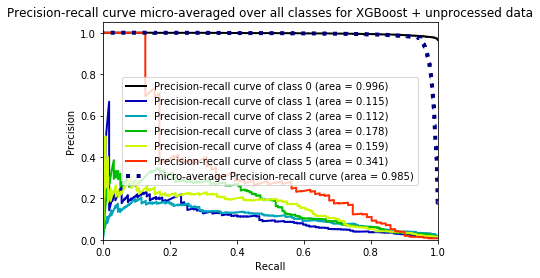

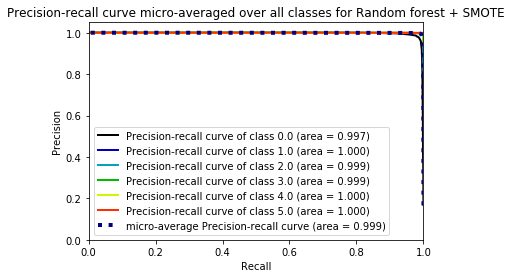

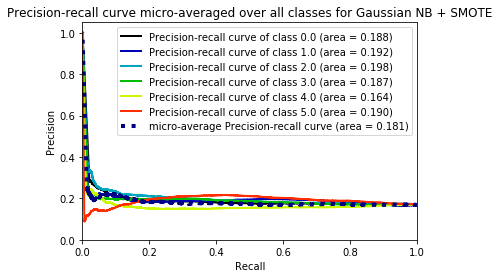

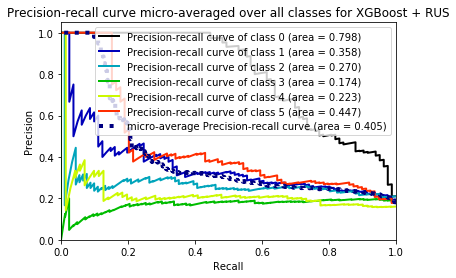

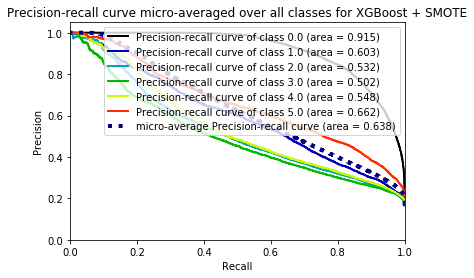

In [15]:
test_models = [('../models/xgboost.pkl', X_test, y_test, 'XGBoost + unprocessed data'),
          ('../models/random_forest_SMOTE.pkl', X_test_smote, y_test_smote, 'Random forest + SMOTE'),
          ('../models/gaussian_nb_SMOTE.pkl', X_test_smote, y_test_smote, 'Gaussian NB + SMOTE'),
          ('../models/xgboost_RUS.pkl', X_test_rus, y_test_rus, 'XGBoost + RUS'),
          ('../models/xgboost_SMOTE.pkl', X_test_smote, y_test_smote, 'XGBoost + SMOTE')
         ]

for in_dir, X_test, y_test, title in test_models:    
    validate(in_dir, X_test, y_test, title)

Results:
1. XGBoost classifier tends to classify non-bankrupted companies on the data with companies being non-bakrupted event rate more than 95%, but fails to classify other classes observations;
2. Random forest classifier with default parameters run on oversampled and imputed data (SMOTE)leads to micro-average AUC around 0.999, but there is a high risk that this model is overfitted;
3. Naive Bayes classifier performs poorly on oversampled and imputed data (SMOTE), AUC < 0.5;
4. XGBoost classifier tends to classify non-bankrupted companies on the data with companies being non-bakrupted event rate around 79%, but fails to classify other classes observations;
5. XGBoost classifier fitted to the data oversampled with SMOTE and imputed data leads to the mirco-average precision-recall rate only 0.638, but performs better in identifying classes compared with XGBoost classifier fitted on original imbalanced data.


According to the results, it is necessary to tune parameters for random forest classifier to avoid overfitting.

Moreover, adaptive boosting might be helpful if we would like to improve model performance by combining several weak estimators.

Drop missing values before performing SMOTE, run grid search (5 folds) for tuning maximum depth of the tree estimator, and compare: a) random forest classifier, b) AdaBoost classifier.

In [16]:
df.dropna(inplace=True)
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,bankruptcy_after_years
0,0.200550,0.37951,0.396410,2.0472,32.351,0.388250,0.249760,1.33050,1.1389,0.50494,...,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,0,0
8,0.009020,0.63202,0.053735,1.1263,-37.842,0.000000,0.014434,0.58223,1.3332,0.36798,...,0.024512,0.84165,0.340940,9.9665,4.2382,116.500,3.1330,2.56030,0,0
12,0.266690,0.34994,0.611470,3.0243,43.087,0.559830,0.332070,1.85770,1.1268,0.65006,...,0.410250,0.88750,0.073630,9.5593,5.6298,38.168,9.5629,33.41300,0,0
13,0.067731,0.19885,0.081562,2.9576,90.606,0.212650,0.078063,4.02900,1.2570,0.80115,...,0.084542,0.79556,0.196190,8.2122,2.7917,60.218,6.0613,0.28803,0,0
14,-0.029182,0.21131,0.452640,7.5746,57.844,0.010387,-0.034653,3.73240,1.0241,0.78869,...,-0.037001,0.97644,0.180630,3.4646,11.3380,31.807,11.4750,1.65110,0,0


In [17]:
df.shape

(19509, 66)

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

all_frs = df[df.columns.difference(['bankruptcy_after_years', 'class'])] # with NaNs
label = df['bankruptcy_after_years']

sm = SMOTE(random_state=111)
X_smote, y_smote = sm.fit_resample(all_frs, label)

param_grid = { 
    'max_depth' : [3,5,7,10]
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
CV_rfc.fit(X_smote, y_smote)

CV_rfc.best_params_


{'max_depth': 10}

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {'base_estimator__max_depth' : [3,5,7,10],
              'base_estimator':[DecisionTreeClassifier()]}

CV_rfc = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, cv=5)
CV_rfc.fit(X_smote, y_smote)

CV_rfc.best_params_

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'base_estimator__max_depth': 10}

According to grid search, both random forest and AdaBoost classifiers perform better with maximum depth 10 with decision tree base estimator.

Create train-test splits for SMOTE samples having no missing values:

In [19]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3)

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



models = [(RandomForestClassifier(max_depth=10), X_train_smote, y_train_smote, '../models/random_forest_SMOTE_no_nan.pkl'),
          (AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10)), X_train_smote, y_train_smote, '../models/adaboost_SMOTE_no_nan.pkl')
         ]

for clr, frs, label, out_dir in models:    
    save_model(clr, frs, label, out_dir)

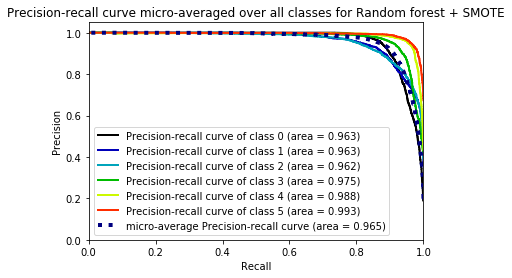

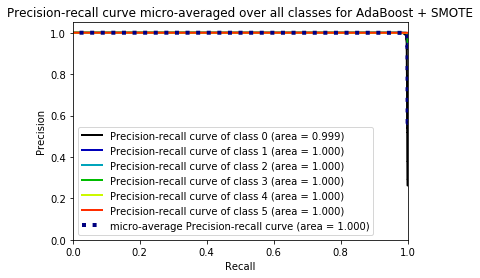

In [24]:
test_models = [('../models/random_forest_SMOTE_no_nan.pkl', X_test_smote, y_test_smote, 'Random forest + SMOTE'),
          ('../models/adaboost_SMOTE_no_nan.pkl', X_test_smote, y_test_smote, 'AdaBoost + SMOTE')]

for in_dir, X_test, y_test, title in test_models:    
    validate(in_dir, X_test, y_test, title)

- As it is seen from the two plots above, AdaBoost classifier is likely to be overfitted on oversampled (SMOTE) data (missing values preliminarly eliminated).
- The best classifier is random forest that was fitted on oversampled (SMOTE) data with preliminarly dropped missing values, area under the precision-recall curve is 0.965 with keeping all features. Tha main drawback of this model is the high risk of having deleted the observations that might be population representatives: around 50% of samples were deleted before applying synthetic oversampling.